# Importing the dependencies

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the Data

In [2]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [4]:
print(f'Original Dataset : {df.shape}')

# using a small portion of dataset 
df = df.head(1000)
print(f'Sample Dataset : {df.shape}')

Original Dataset : (568454, 10)
Sample Dataset : (1000, 10)


Thus, there are 10 columns out of which Score determines the review rating of food and Text describes the comment on that food.

# Quick EDA

In [5]:
# percentage composition of the sample dataset
percentage = (df['Score'].value_counts())/(np.sum(df['Score'].value_counts()))
percentage

5    0.642
4    0.138
1    0.098
3    0.075
2    0.047
Name: Score, dtype: float64

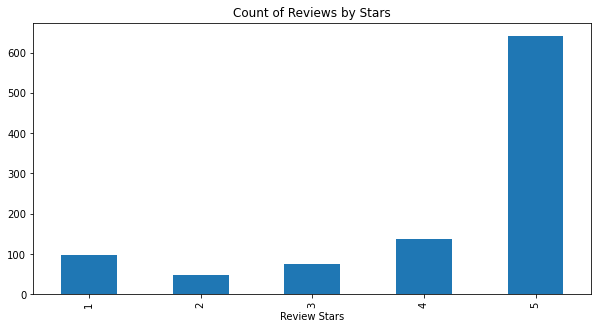

In [6]:
ax = df['Score'].value_counts().sort_index() \
        .plot(kind='bar',title='Count of Reviews by Stars',
             figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

# Basic nltk

In [7]:
# taking random text as example
example = df['Text'][500]
example

"I bought these for the office and no one can put them down. I'm ordering more today and it has only been 2 weeks. Didn't have to shop for them either, Amazon brought it to my door!"

In [8]:
# Tokenizing the example using nltk
tokens = nltk.word_tokenize(example)
tokens

['I',
 'bought',
 'these',
 'for',
 'the',
 'office',
 'and',
 'no',
 'one',
 'can',
 'put',
 'them',
 'down',
 '.',
 'I',
 "'m",
 'ordering',
 'more',
 'today',
 'and',
 'it',
 'has',
 'only',
 'been',
 '2',
 'weeks',
 '.',
 'Did',
 "n't",
 'have',
 'to',
 'shop',
 'for',
 'them',
 'either',
 ',',
 'Amazon',
 'brought',
 'it',
 'to',
 'my',
 'door',
 '!']

In [9]:
# declaring part of speech using pos_tag from nltk
tag = nltk.pos_tag(tokens)
tag

[('I', 'PRP'),
 ('bought', 'VBD'),
 ('these', 'DT'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('office', 'NN'),
 ('and', 'CC'),
 ('no', 'DT'),
 ('one', 'NN'),
 ('can', 'MD'),
 ('put', 'VB'),
 ('them', 'PRP'),
 ('down', 'RP'),
 ('.', '.'),
 ('I', 'PRP'),
 ("'m", 'VBP'),
 ('ordering', 'VBG'),
 ('more', 'JJR'),
 ('today', 'NN'),
 ('and', 'CC'),
 ('it', 'PRP'),
 ('has', 'VBZ'),
 ('only', 'RB'),
 ('been', 'VBN'),
 ('2', 'CD'),
 ('weeks', 'NNS'),
 ('.', '.'),
 ('Did', 'VBP'),
 ("n't", 'RB'),
 ('have', 'VB'),
 ('to', 'TO'),
 ('shop', 'VB'),
 ('for', 'IN'),
 ('them', 'PRP'),
 ('either', 'DT'),
 (',', ','),
 ('Amazon', 'NNP'),
 ('brought', 'VBD'),
 ('it', 'PRP'),
 ('to', 'TO'),
 ('my', 'PRP$'),
 ('door', 'NN'),
 ('!', '.')]

# VADER Sentiment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.
This uses a "bag of words" approach to classify the text.

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [11]:
# checking polarity scores of some random text
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [12]:
sia.polarity_scores(example)

{'neg': 0.067, 'neu': 0.887, 'pos': 0.046, 'compound': -0.2003}

Thus, it states that the example taken above is much inclined towards negative side.

In [13]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [15]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Plotting VADER results

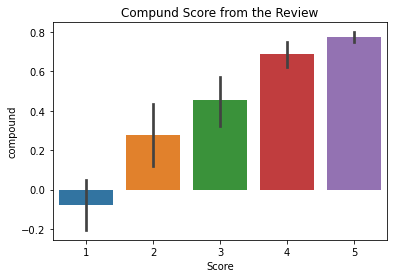

In [16]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score from the Review')
plt.show()

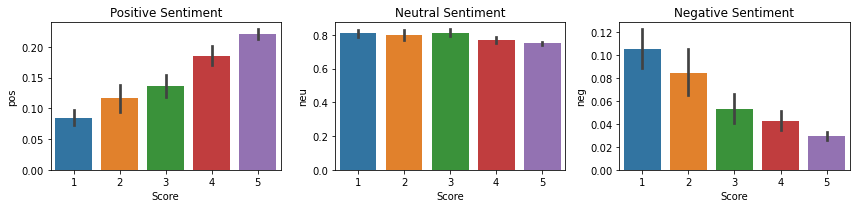

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive Sentiment')
axs[1].set_title('Neutral Sentiment')
axs[2].set_title('Negative Sentiment')
plt.tight_layout()
plt.show()

# Pre-trained RoBERTa model

The benefits of utilizing Transformer model is that it accounts for not only the words but also the context related to other words.

In [18]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [19]:
# importing the pretrained model's learned weights
model = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [20]:
# Defining a polarity score calculator for RoBERTa
def roberta_polarity_scores(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [21]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = roberta_polarity_scores(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Error in loading for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Error in loading for id 83
Error in loading for id 187
Error in loading for id 529
Error in loading for id 540
Error in loading for id 746
Error in loading for id 863


In [22]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

# Comparing results from both the models

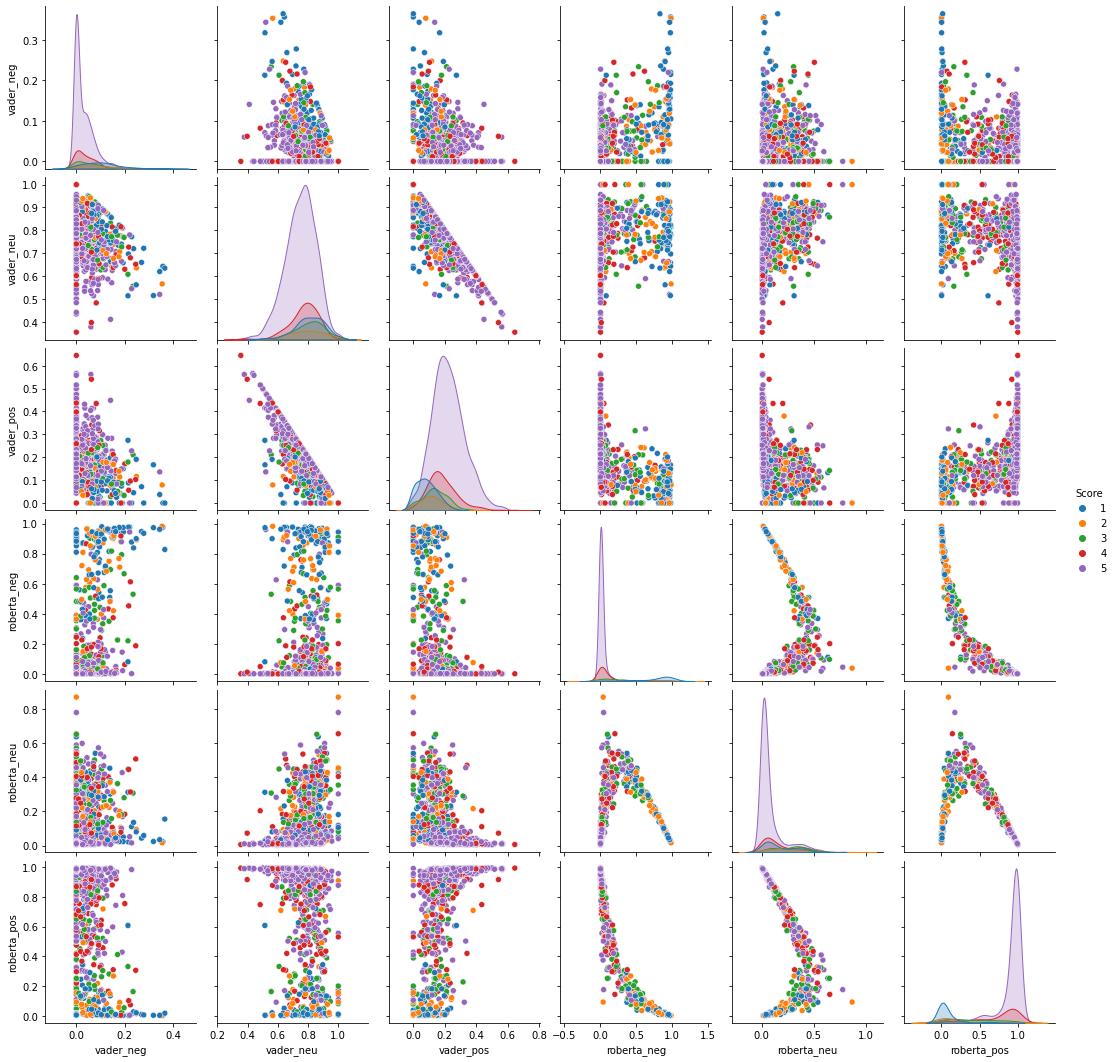

In [23]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()